[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shezan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shezan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shezan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Epoch 1/20


C:\Users\Shezan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


371/371 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.2942 - loss: -12.4644 - val_accuracy: 0.2941 - val_loss: -37.5402
Epoch 2/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.2959 - loss: -41.9975 - val_accuracy: 0.2941 - val_loss: -66.4792
Epoch 3/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.2836 - loss: -70.8756 - val_accuracy: 0.2941 - val_loss: -94.9881
Epoch 4/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.2940 - loss: -98.4838 - val_accuracy: 0.2941 - val_loss: -123.8559
Epoch 5/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2911 - loss: -131.2554 - val_accuracy: 0.2941 - val_loss: -168.7113
Epoch 6/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2991 - loss: -177.3180 - val_accuracy: 0.2972 - val_loss: -207.3686
Epoch 7/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.3031 - loss: -214.2138 - val_accuracy: 0.3083 - val_loss: -246.5157
Epoch 8/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 

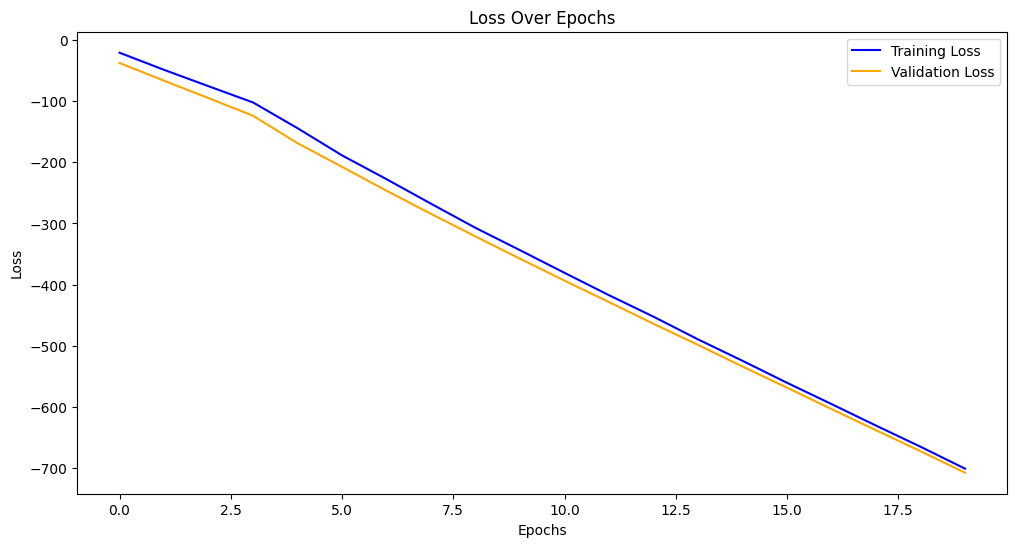

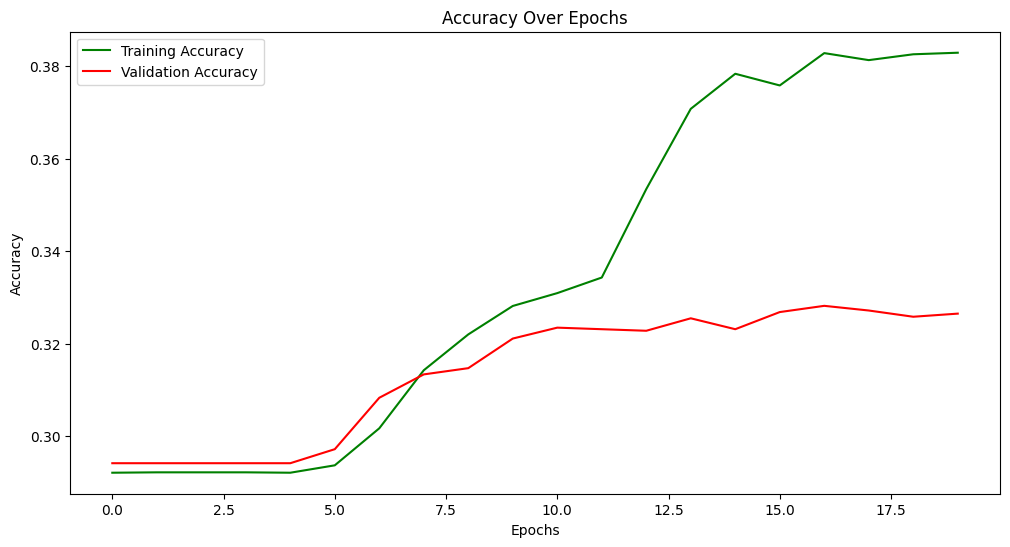

In [4]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Step 2: Load Dataset
data = pd.read_csv('TD.csv')  # Replace 'TD.csv' with the actual path to your dataset

# Ensure the column names are correct
data.columns = ['category', 'sentiment', 'text']  # Rename columns if necessary
data = data.dropna(subset=['text', 'sentiment'])  # Drop rows with missing values

# Step 3: Preprocess Text Data
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):  # Ensure input is a string
        text = ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters, digits, and punctuation
    stop_words = set(stopwords.words('english'))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization
    return text

# Apply preprocessing
data['text'] = data['text'].apply(preprocess_text)

# Step 4: Tokenize Text Data
vocab_size = 10000  # Vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['text'])  # Fit tokenizer on preprocessed text
X = tokenizer.texts_to_sequences(data['text'])  # Convert text to sequences

# Pad sequences to ensure uniform length
max_sequence_length = 200
X = pad_sequences(X, maxlen=max_sequence_length)

# Step 5: Encode Sentiment Labels
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])  # Encode sentiments as integers
y = data['sentiment'].values

# Step 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Build the Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))  # Added recurrent dropout
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

# Step 9: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Step 10: Save Tokenizer (optional)
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Step 11: Visualize Training Progress
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/10


C:\Users\Shezan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


8141/8141 ━━━━━━━━━━━━━━━━━━━━ 448s 55ms/step - accuracy: 0.7833 - loss: 0.5813 - val_accuracy: 0.9381 - val_loss: 0.1015
Epoch 2/10
8141/8141 ━━━━━━━━━━━━━━━━━━━━ 449s 55ms/step - accuracy: 0.9382 - loss: 0.1092 - val_accuracy: 0.9394 - val_loss: 0.0935
Epoch 3/10
8141/8141 ━━━━━━━━━━━━━━━━━━━━ 446s 55ms/step - accuracy: 0.9398 - loss: 0.0982 - val_accuracy: 0.9409 - val_loss: 0.0925
Epoch 4/10
8141/8141 ━━━━━━━━━━━━━━━━━━━━ 446s 55ms/step - accuracy: 0.9415 - loss: 0.0935 - val_accuracy: 0.9402 - val_loss: 0.0951
Epoch 5/10
8141/8141 ━━━━━━━━━━━━━━━━━━━━ 449s 55ms/step - accuracy: 0.9432 - loss: 0.0907 - val_accuracy: 0.9399 - val_loss: 0.0948
Epoch 6/10
8141/8141 ━━━━━━━━━━━━━━━━━━━━ 457s 56ms/step - accuracy: 0.9422 - loss: 0.0888 - val_accuracy: 0.9395 - val_loss: 0.0972
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - accuracy: 0.9406 - loss: 0.0927
Test Accuracy: 0.9409
4885/4885 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step
Precision: 0.9425, Recall: 0.9409, F1-Score: 0.9409


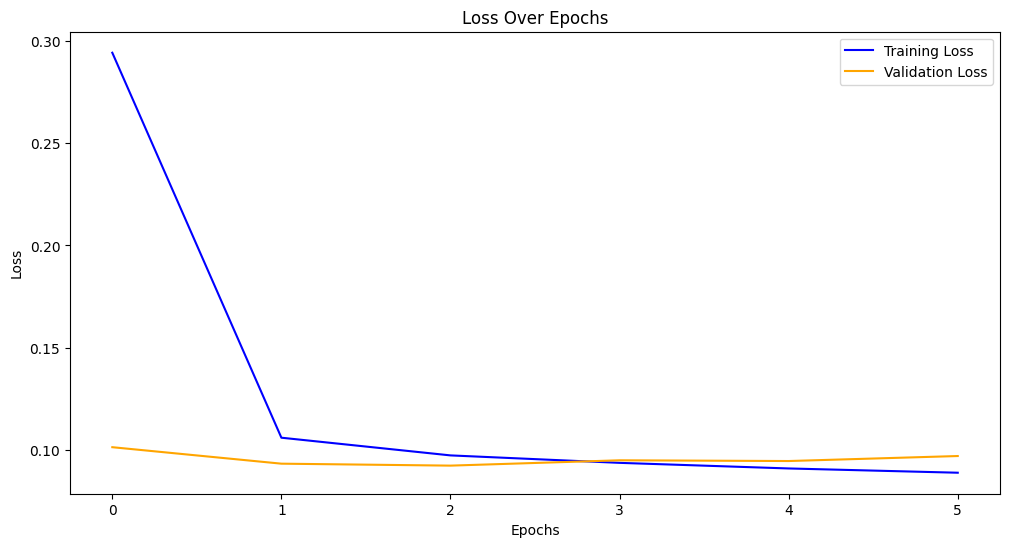

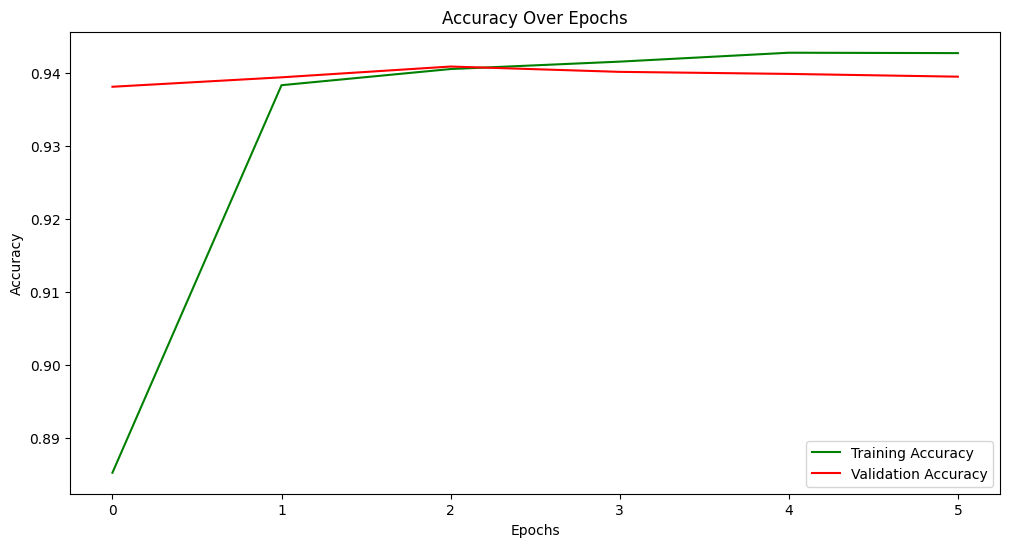

In [6]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Step 2: Load and Preprocess Data
data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

# Split data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
)

# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower().strip())  # Remove special characters
    return text

train_texts = train_texts.apply(preprocess_text)
test_texts = test_texts.apply(preprocess_text)

# Tokenization and Padding
vocab_size = 20000
max_sequence_length = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding="post", truncating="post")

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

# Step 3: Build the RNN Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(data["label"].unique()), activation="softmax")  # For multi-class classification
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Step 4: Train the Model
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_rnn_model.keras", monitor="val_loss", save_best_only=True, mode="min")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

# Step 5: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute Precision, Recall, F1-Score
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average="weighted")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Step 6: Save the Tokenizer (Optional)
import pickle
with open("rnn_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Step 7: Visualize Training Progress
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", color="green")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="red")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


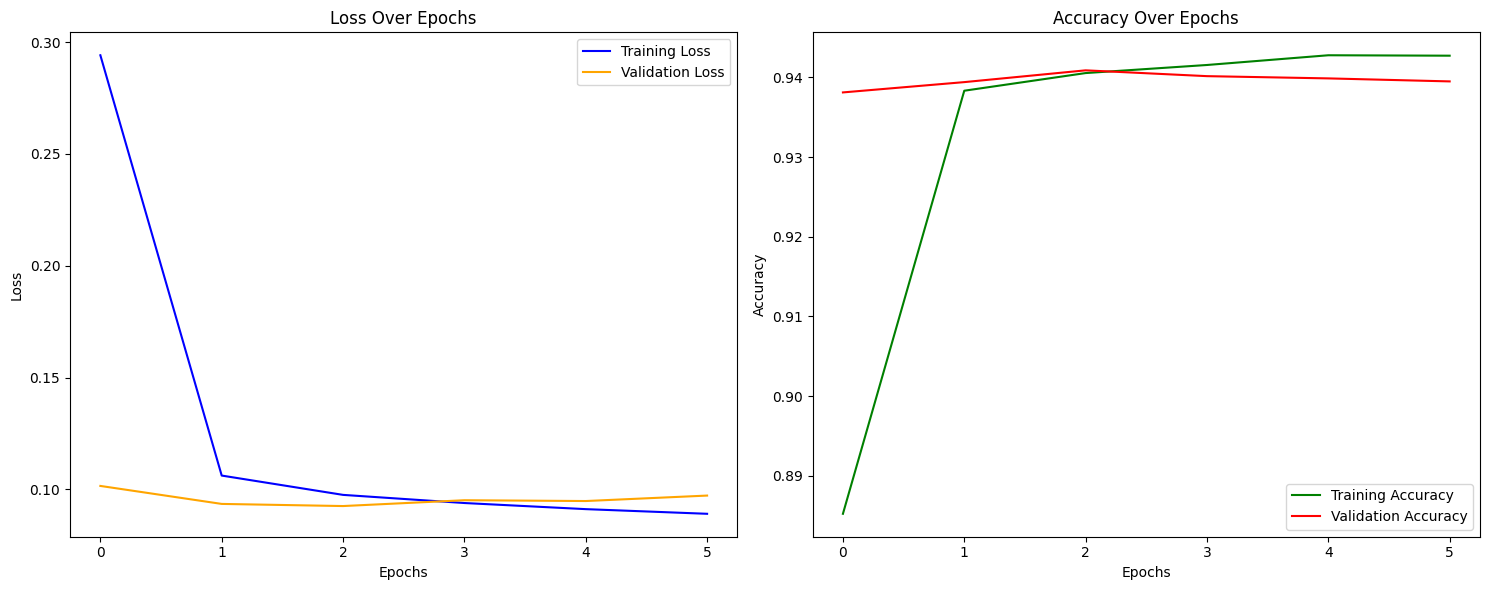

In [8]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot training and validation loss on the first axis
axes[0].plot(history.history["loss"], label="Training Loss", color="blue")
axes[0].plot(history.history["val_loss"], label="Validation Loss", color="orange")
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot training and validation accuracy on the second axis
axes[1].plot(history.history["accuracy"], label="Training Accuracy", color="green")
axes[1].plot(history.history["val_accuracy"], label="Validation Accuracy", color="red")
axes[1].set_title("Accuracy Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()
